In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Constants
MAX_CARS = 20
MAX_MOVE = 5
RENTAL_REWARD = 10
MOVEMENT_COST = 2
DISCOUNT_FACTOR = 0.9
REQUEST_MEAN_L1 = 3  # Poisson mean for location 1 requests
REQUEST_MEAN_L2 = 4  # Poisson mean for location 2 requests
RETURN_MEAN_L1 = 3   # Poisson mean for location 1 returns
RETURN_MEAN_L2 = 2   # Poisson mean for location 2 returns

In [ ]:
state_space = [(x1, x2) for x1 in range(MAX_CARS + 1) for x2 in range(MAX_CARS + 1)]

action_space = list(range(-MAX_MOVE, MAX_MOVE + 1))

In [305]:
def poisson(lda,x):
    return stats.poisson.pmf(x, lda)
def poissonc(lda,x):
    return stats.poisson.cdf(x, lda)

def pp(state,action,V):
    k1 = min(state[0]+action,20)
    k2 = min(state[1]-action,20)
    sums = -abs(action)*2
    for i in range(21):
        for j in range(21):
            sums+= psingle((k1,k2),(i,j),V)
    return sums
def psingle(state1,state2,V):
    k1 = state1[0]
    k2 = state1[1]
    i = state2[0]
    j = state2[1]
    return poisson(3,k1-i)*poisson(4,k2-j)*((max(k1-i,0)+max(k2-j,0))*10+0.9*V[((max(k1-i,0),max(k2-j,0)))])

In [306]:
# Plot the policy change (heatmap) for the current iteration
def plot_policy(policy, iteration):
    # Prepare a 21x21 grid for policy visualization
    policy_grid = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    
    # Fill in the grid with actions from the policy
    for x1 in range(MAX_CARS + 1):
        for x2 in range(MAX_CARS + 1):
            policy_grid[x1, x2] = policy[(x1, x2)]

    # Plot the heatmap (we can choose different colors for actions)
    plt.figure(figsize=(6, 5))
    plt.imshow(policy_grid, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Number of Cars Moved')
    plt.title(f'Policy at Iteration {iteration}')
    plt.xlabel('Location 2 Cars')
    plt.ylabel('Location 1 Cars')
    plt.xticks(np.arange(0, MAX_CARS + 1, 5))
    plt.yticks(np.arange(0, MAX_CARS + 1, 5))
    plt.show()


In [592]:
def policy_iteration():
    policy = {(x1, x2): 0 for (x1, x2) in state_space}
    
    V = {(x1, x2): 0 for (x1, x2) in state_space}
    
    def policy_evaluation():
        tolerance = 0.00001  # Convergence tolerance
        while True:
            delta = 0
            for state in state_space:
                v = V[state]
                action = policy[state]
                offset = 0
                if state[0]+action>20:
                    offset = max(offset,state[0]+action-20)
                if state[0]+action<0:
                    offset = max(offset,-state[0]-action)
                if state[1]-action>20:
                    offset = max(offset,state[1]-action-20)
                if state[1]-action<0:
                    offset = max(offset,-state[1]+action)
                
                if action>0:
                    act = action - offset
                else:
                    act = action + offset
                s1 = state[0]+act
                s2 = state[1]-act

                state_sum = 0 
                for state_prime in state_space:
                    s1_p = state_prime[0]
                    s2_p = state_prime[1]
                    prob = transition_prob[s1,s1_p,s2,s2_p]
                    r = reward[s1,s1_p,s2,s2_p]  -abs(action)*2/prob
                    state_sum += prob*(r + 0.9*V[(s1_p,s2_p)])
                V[state] = state_sum
                delta = max(delta, abs(v - V[state]))
            if delta < tolerance:
                break

    # Helper function: policy improvement
    def policy_improvement():
        policy_stable = True
        for state in state_space:
            old_action = policy[state]
            # Choose the action that maximizes the expected value
            action_values = []
            for action in action_space:
                offset = 0
                if state[0]+action>20:
                    offset = max(offset,state[0]+action-20)
                if state[0]+action<0:
                    offset = max(offset,-state[0]-action)
                if state[1]-action>20:
                    offset = max(offset,state[1]-action-20)
                if state[1]-action<0:
                    offset = max(offset,-state[1]+action)
                
                if action>0:
                    act = action - offset
                else:
                    act = action + offset
                action_value = V[(state[0]+act,state[1]-act)]
                action_values.append(action_value)
            best_action = action_space[np.argmax(action_values)]
            policy[state] = best_action
            if old_action != best_action:
                policy_stable = False
        return policy_stable

    # Iterate until the policy converges
    iteration = 0
    while True:
        print(f"Iteration {iteration}: Policy")
        plot_policy(policy, iteration)  # Plot policy map for each iteration
        policy_evaluation()
        if policy_improvement():
            plot_policy(policy, iteration)
            break
        iteration += 1


Iteration 0: Policy


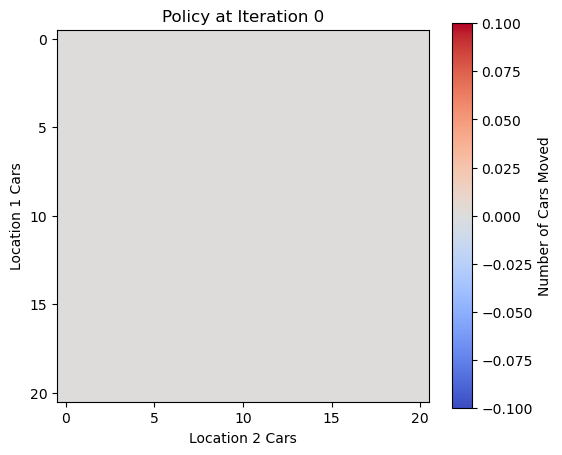

Iteration 1: Policy


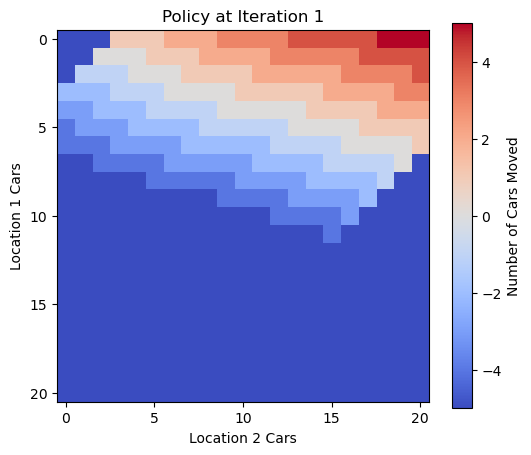

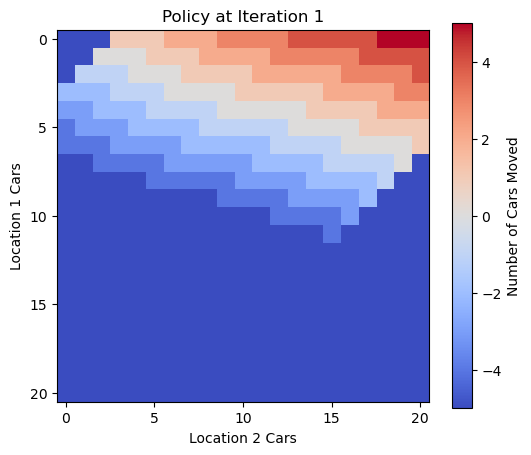

In [593]:
# Run the policy iteration
policy_iteration()

In [ ]:
s1_rent = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1 in range(MAX_CARS + 1):
    for car2 in range(MAX_CARS + 1):
        if car2 == 0:
            s1_rent[car1,car2]  = 1 - poissonc(3,car1-car2-1)
        else:
            s1_rent[car1,car2]  = poisson(3,car1-car2)

s1_return = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1 in range(MAX_CARS + 1):
    for car2 in range(MAX_CARS + 1):
        if car2 == MAX_CARS:
            s1_return[car1,car2]  = 1- poissonc(3,car2-car1-1)
        else:
            s1_return[car1,car2]  = poisson(3,car2-car1)

s2_rent = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1 in range(MAX_CARS + 1):
    for car2 in range(MAX_CARS + 1):
        if car2 == 0:
            s2_rent[car1,car2]  = 1 - poissonc(4,car1-car2-1)
        else:
            s2_rent[car1,car2]  = poisson(4,car1-car2)

s2_return = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
for car1 in range(MAX_CARS + 1):
    for car2 in range(MAX_CARS + 1):
        if car2 == MAX_CARS:
            s2_return[car1,car2]  = 1- poissonc(2,car2-car1-1)
        else:
            s2_return[car1,car2]  = poisson(2,car2-car1)

In [586]:
transition_prob = np.zeros((MAX_CARS + 1, MAX_CARS + 1, MAX_CARS+1, MAX_CARS+1))
reward = np.zeros((MAX_CARS + 1, MAX_CARS + 1,MAX_CARS+1,MAX_CARS+1))
for s1_car1 in range(MAX_CARS + 1):
    for s1_car2 in range(MAX_CARS + 1):
        for s2_car1 in range(MAX_CARS + 1):
            for s2_car2 in range(MAX_CARS + 1):
                ss = 0
                r = 0
                for s1_mid in range(MAX_CARS +1):
                    for s2_mid in range(MAX_CARS +1):
                        p1 = s1_rent[s1_car1,s1_mid]*s1_return[s1_mid,s1_car2]
                        p2 = s2_rent[s2_car1,s2_mid]*s2_return[s2_mid,s2_car2]
                        ss += p1*p2
                        r += p1*p2*(s1_car1+s2_car1-s1_mid-s2_mid)*10
                transition_prob[s1_car1,s1_car2,s2_car1,s2_car2] = ss
                reward[s1_car1,s1_car2,s2_car1,s2_car2] = r/ss

In [534]:
eff= 0
for j in range(21):
    for i in range(21):
        eff+=transition_prob[10,i,0,j]
print(eff)

1.0


In [587]:
eff= 0

from_x = 20
from_y = 19
for j in range(21):
    for i in range(21):
        eff+=reward[from_x,i,from_y,j]*transition_prob[from_x,i,from_y,j]
print(eff)

69.99999987444934


In [585]:
reward[20,20,20,20]/transition_prob[20,20,20,20]

43.361128158315914

In [583]:
eff= 0

from_x = 19
from_y = 19
for j in range(21):
    for i in range(21):
        eff+=reward[from_x,i,from_y,j]
print(eff)

69.99999987361791


In [555]:
transition_prob[20,20,20,20]

0.15752176802759046

In [554]:
reward[20,20,20,11]

0.2691321692878009

In [525]:
transition_prob = np.zeros((MAX_CARS + 1, MAX_CARS + 1, MAX_CARS+1, MAX_CARS+1))
reward = np.zeros((MAX_CARS + 1, MAX_CARS + 1,MAX_CARS+1,MAX_CARS+1))
for s1_car1 in range(20,21):
    for s1_car2 in range(20,21):
        for s2_car1 in range(MAX_CARS + 1):
            for s2_car2 in range(MAX_CARS + 1):
                ss = 0
                r = 0
                for s1_mid in range(MAX_CARS +1):
                    for s2_mid in range(MAX_CARS +1):
                        p1 = s1_rent[s1_car1,s1_mid]*s1_return[s1_mid,s1_car2]
                        p2 = s2_rent[s2_car1,s2_mid]*s2_return[s2_mid,s2_car2]
                        ss += p1*p2
                        r += p1*p2*(s1_car1+s2_car1-s1_mid-s2_mid)*10
                transition_prob[s1_car1,s1_car2,s2_car1,s2_car2] = ss
                reward[s1_car1,s1_car2,s2_car1,s2_car2] = r

In [ ]:
# Plot the policy change (heatmap) for the current iteration
def plot_reward(V):
    # Prepare a 21x21 grid for policy visualization
    policy_grid = np.zeros((MAX_CARS + 1, MAX_CARS + 1))
    
    # Fill in the grid with actions from the policy
    for x1 in range(MAX_CARS + 1):
        for x2 in range(MAX_CARS + 1):
            policy_grid[x1, x2] = reward[(x1, x2)]

    # Plot the heatmap (we can choose different colors for actions)
    plt.figure(figsize=(6, 5))
    plt.imshow(policy_grid, cmap='coolwarm', interpolation='nearest')
    plt.colorbar(label='Number of Cars Moved')
    plt.title(f'reward at Iteration')
    plt.xlabel('Location 2 Cars')
    plt.ylabel('Location 1 Cars')
    plt.xticks(np.arange(0, MAX_CARS + 1, 5))
    plt.yticks(np.arange(0, MAX_CARS + 1, 5))
    plt.show()

TypeError: Invalid shape (21, 21, 21, 21) for image data

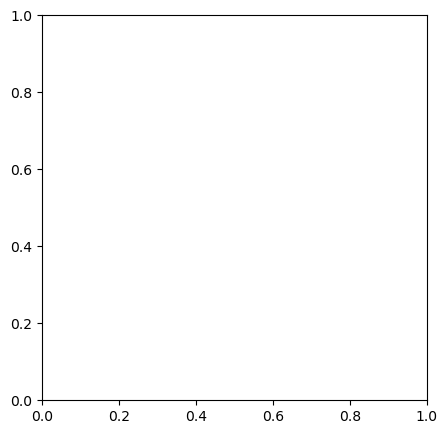

In [595]:
plot_value(reward)